In [29]:
import matplotlib.pyplot as plt
import tarfile as trf
from os import listdir, system
from os.path import isfile, join
import re
import pandas as pd


In [30]:
def getDataset(result_folder):
    files_tgz = [f for f in listdir(result_folder) if isfile(join(result_folder, f))]

    for file in files_tgz:
        if file.endswith(".tgz"):
            tar = trf.open(result_folder + "/" + file, "r:gz")
            tar.extractall(result_folder + "/" + "extract/")
            tar.close()
            
    result_folder_extracted = result_folder + "/extract/"
    bench_res_folder = listdir(result_folder_extracted)   
    bench_results = []

    for fold_name in bench_res_folder:
        
        with open(result_folder_extracted+fold_name+"/slurm_script", "r") as file:
            data = file.read()
            no_of_nodes = (re.findall(r'#SBATCH -N [0-9]*', data)[0]).split()[-1]
            no_of_task = (re.findall(r'#SBATCH --ntasks-per-node=[0-9]*', data)[0]).split("=")[-1]
        
        with open(result_folder_extracted+fold_name+"/result_summary.txt", "r") as file:  
            test_result_data  = "" 
            for line in file.readlines():
                
                benchmark_result = list(line.split())
                if benchmark_result[1]  != "]" and len(benchmark_result) > 7:
                    test_result_data += (benchmark_result[1]) + " " + (benchmark_result[2]) + " " + (benchmark_result[3] + " ") 
                       
            string = str(fold_name + " " + no_of_nodes + " " + no_of_task + " " + result_folder_extracted + " " + fold_name + " " + test_result_data)
            bench_results.append(string.split())
            
            
    system("rm -r " + result_folder + "/extract")
    df = pd.DataFrame(data=bench_results)
    return df
    

In [31]:
def benchmarkGraphPlot(df, benchmarkDataFrameIndex, mainBenchmarkLabel="", compareToBenchmarkLabel="" ,dfCompareTo=None, benchmarkDataFrameIndexCompareTo=None): 
	numb_of_nodes = [ int(i) for i in df[1].unique().tolist() ]
	list.sort(numb_of_nodes)
	tasks = [ int(i) for i in df[2].unique().tolist() ]
	list.sort(tasks)
	tasks = [str(x) for x in tasks]
	
	if dfCompareTo is not None:
		numb_of_nodes_cmp = [ int(i) for i in dfCompareTo[1].unique().tolist() ]
		list.sort(numb_of_nodes_cmp)
		tasks_cmp = [ int(i) for i in dfCompareTo[2].unique().tolist() ]
		list.sort(tasks_cmp)
		tasks_cmp = [str(x) for x in tasks_cmp]

	fig, axs = plt.subplots(len(numb_of_nodes), facecolor="white")
	fig.suptitle(df.iloc[0][benchmarkDataFrameIndex-1])
	fig.set_size_inches(15,15)
	

	for idx, nodes in enumerate(numb_of_nodes):
		legend=[]
		subset_dataframe = df.loc[df[1] == str(nodes)]
		data_list = [ float(x) for x in subset_dataframe[benchmarkDataFrameIndex].to_list()]
		axs[idx].plot(tasks, data_list,"-o", label=tasks)
		legend.append(str(nodes) + " nodes" + " " + mainBenchmarkLabel)
		axs[idx].set_xticks(labels=tasks, rotation=0, ticks=tasks)
		axs[idx].set_xlabel("Number of tasks")
		axs[idx].set_ylabel(df.iloc[0][benchmarkDataFrameIndex+1])
		
		if dfCompareTo is not None:
			subset_dataframe_cmp = dfCompareTo.loc[dfCompareTo[1] == str(nodes)]
			data_list_cmp = [ float(x) for x in subset_dataframe_cmp[benchmarkDataFrameIndexCompareTo].to_list()]
			axs[idx].plot(tasks_cmp, data_list_cmp,"-o", label=tasks)
			legend.append(str(nodes) + " nodes"+ " " + compareToBenchmarkLabel)
			axs[idx].set_ylim(min(min(data_list), min(data_list_cmp))-1, max(max(data_list), max(data_list_cmp))+1)
		else:
			axs[idx].set_ylim(  min(data_list)-0.5, max(data_list)+0.5 )
			
		axs[idx].legend(legend)
	
	plt.savefig(str(df.iloc[0][benchmarkDataFrameIndex-1]) + ".png")

			
	
   
	

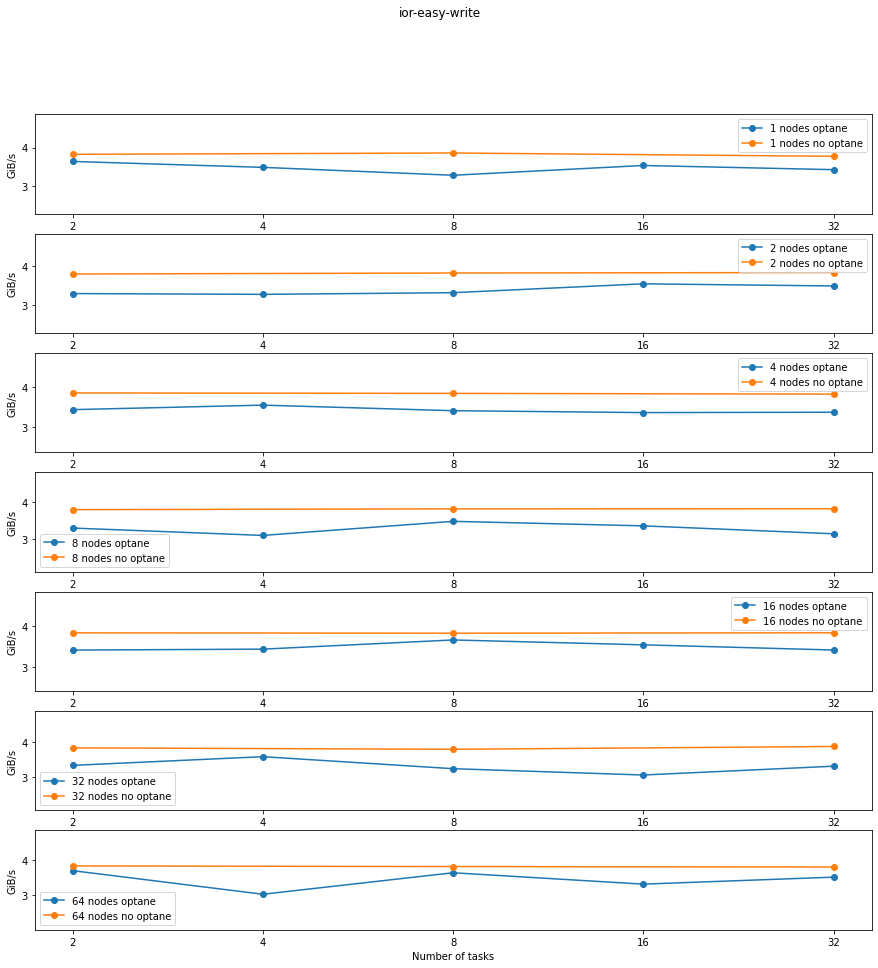

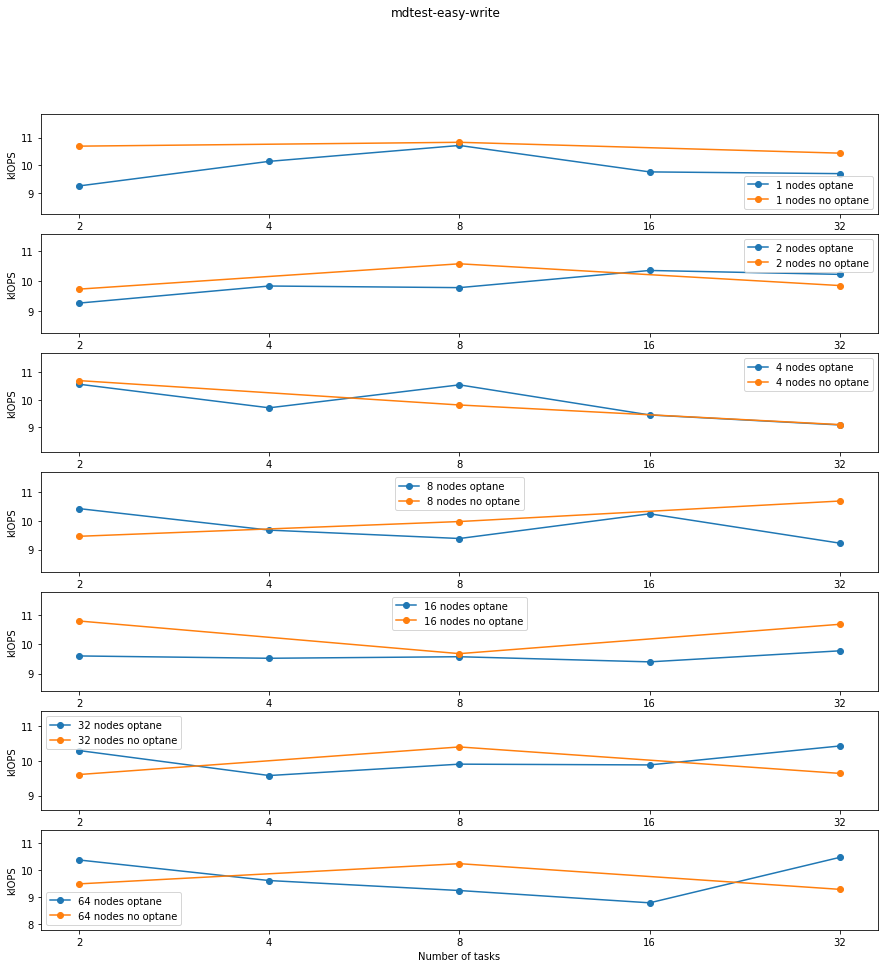

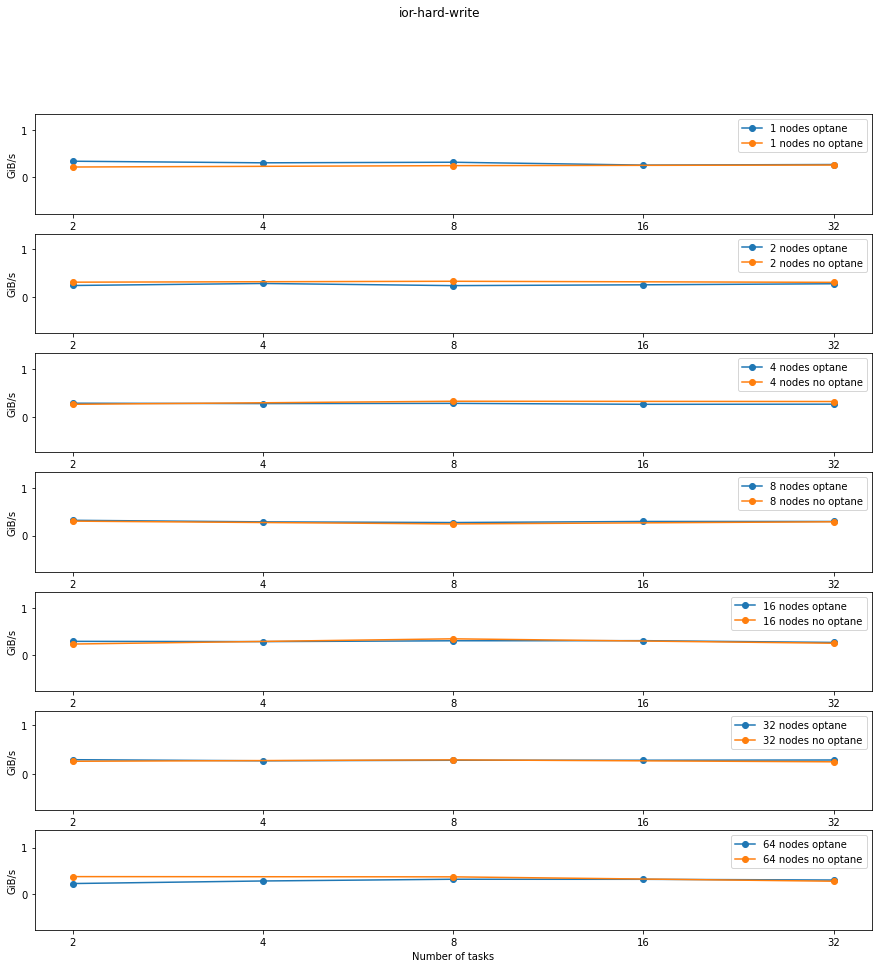

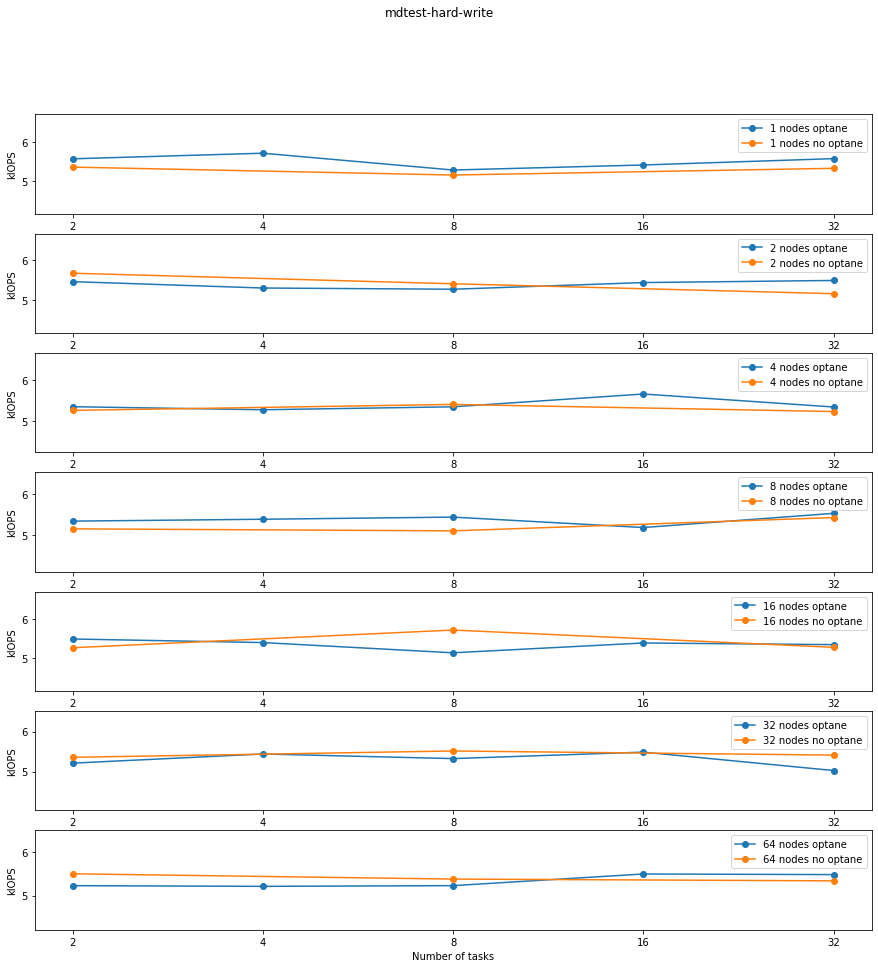

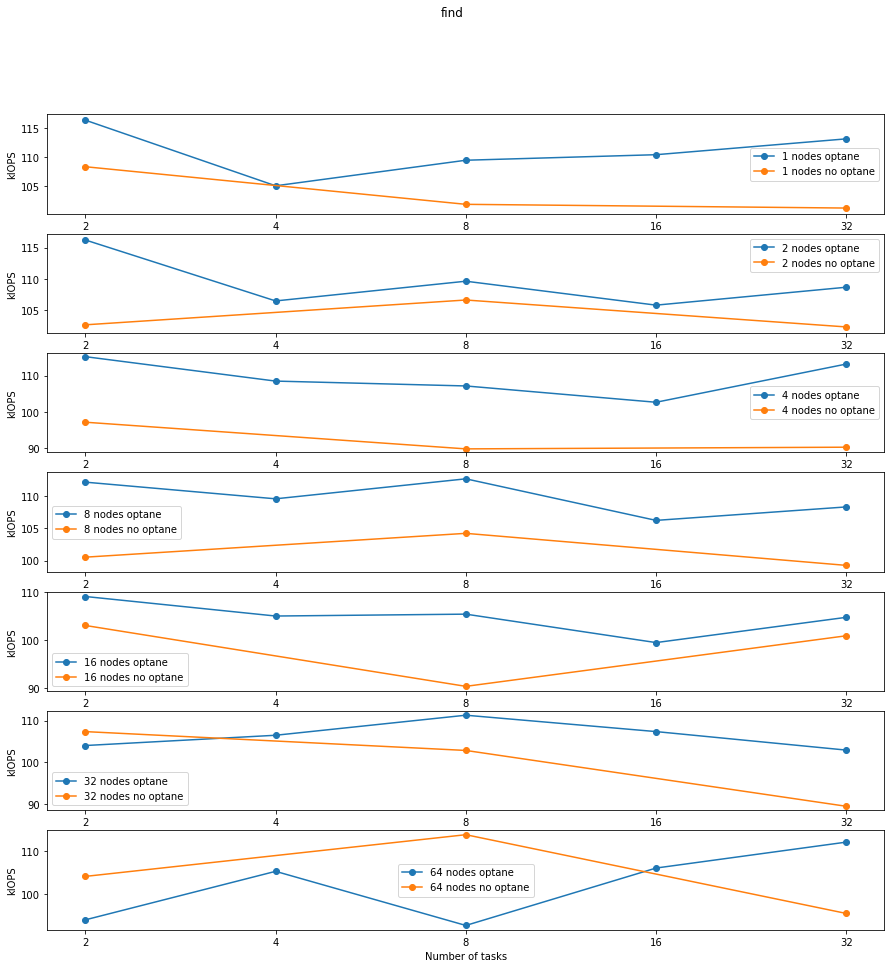

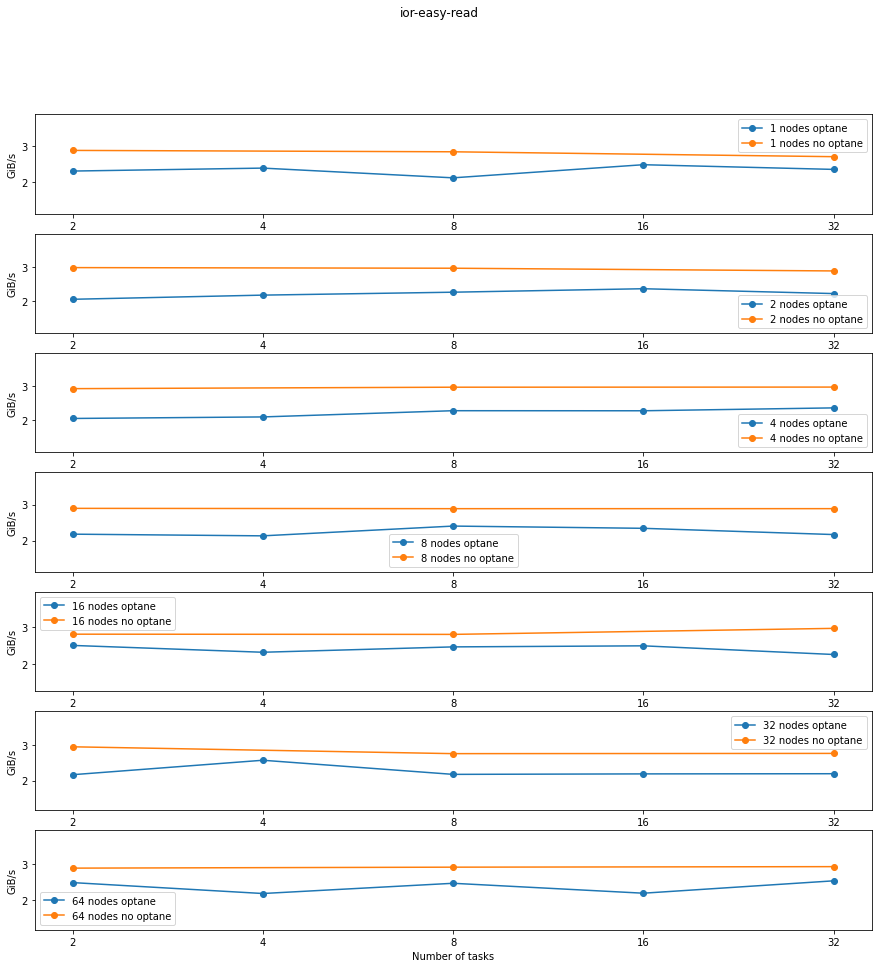

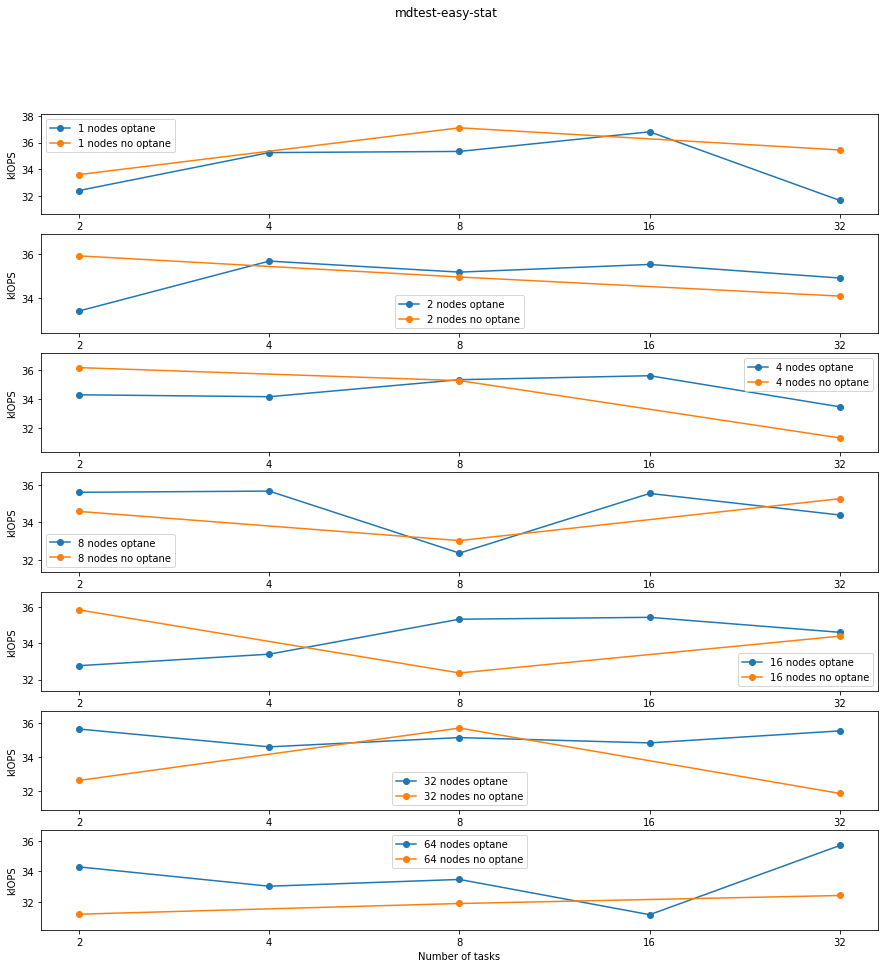

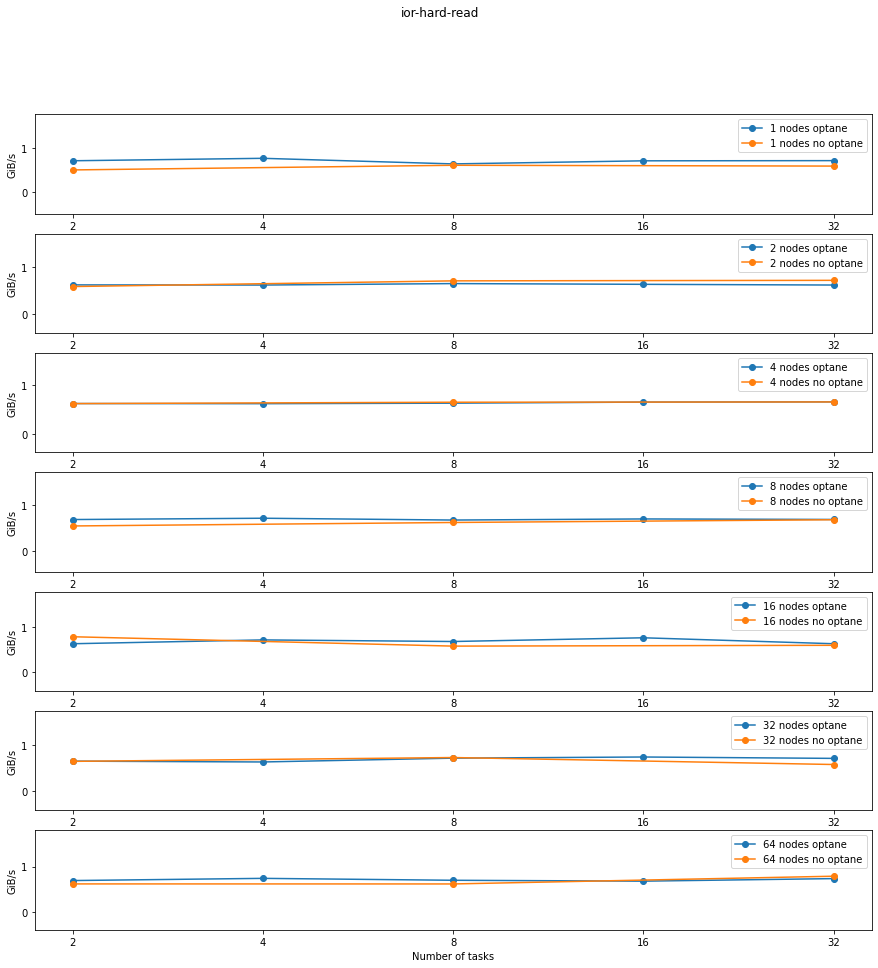

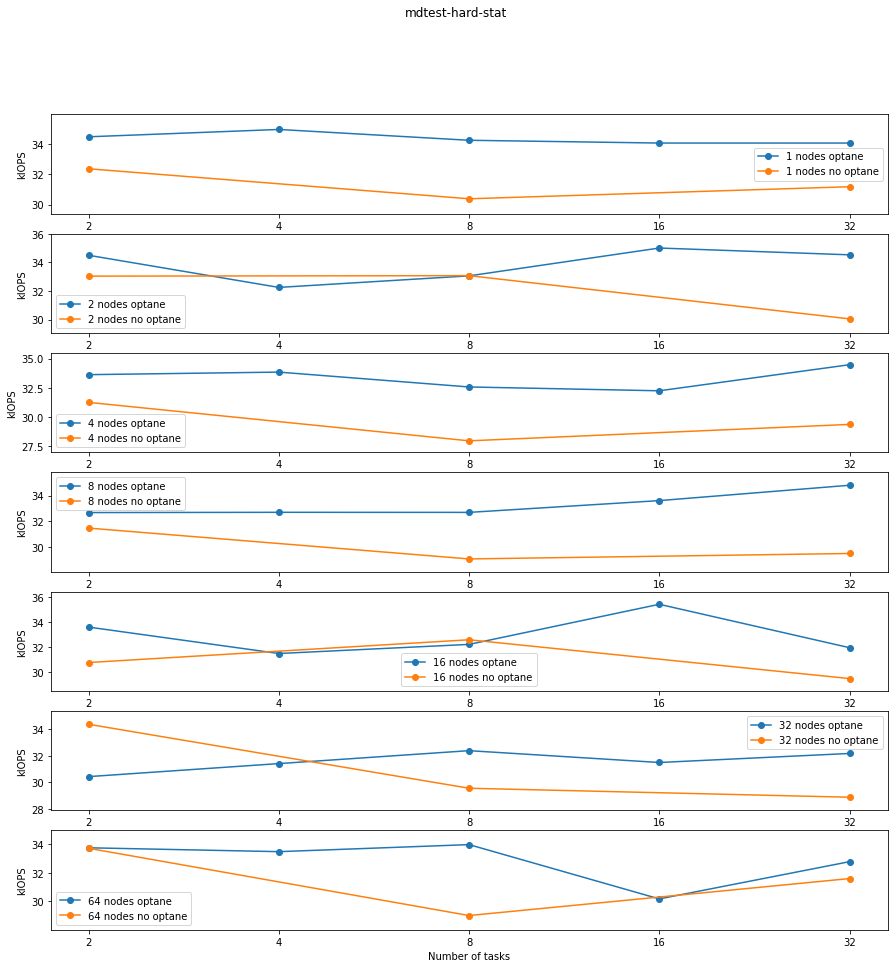

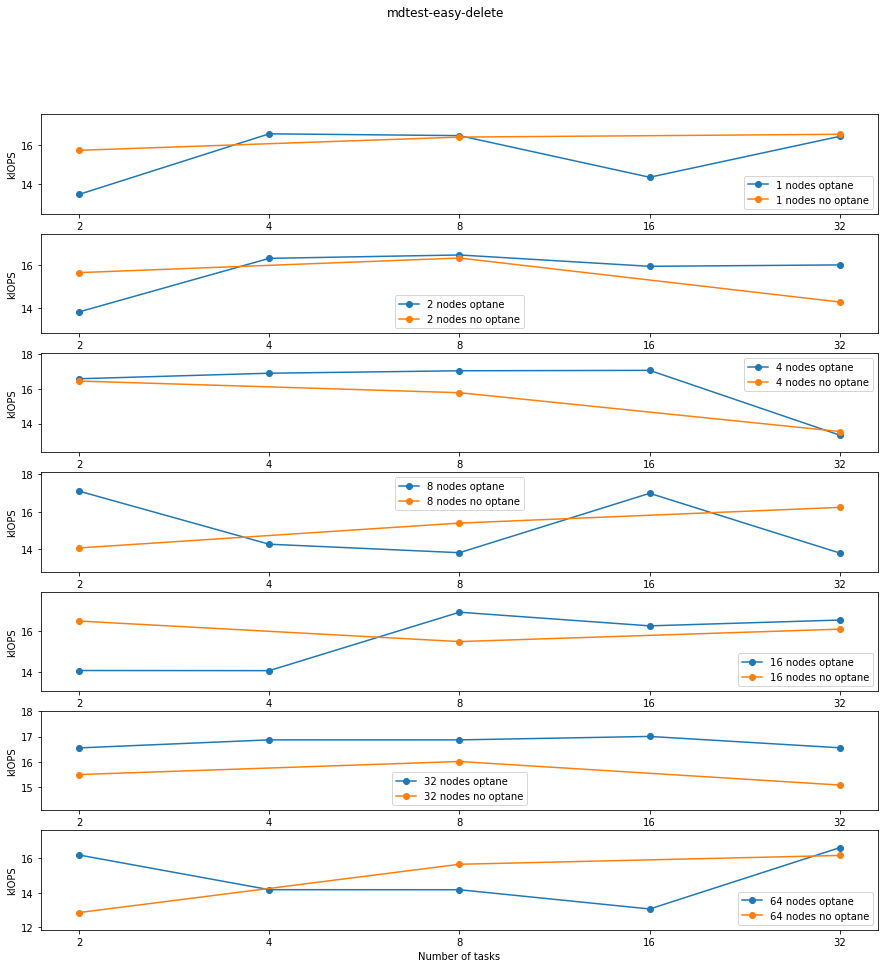

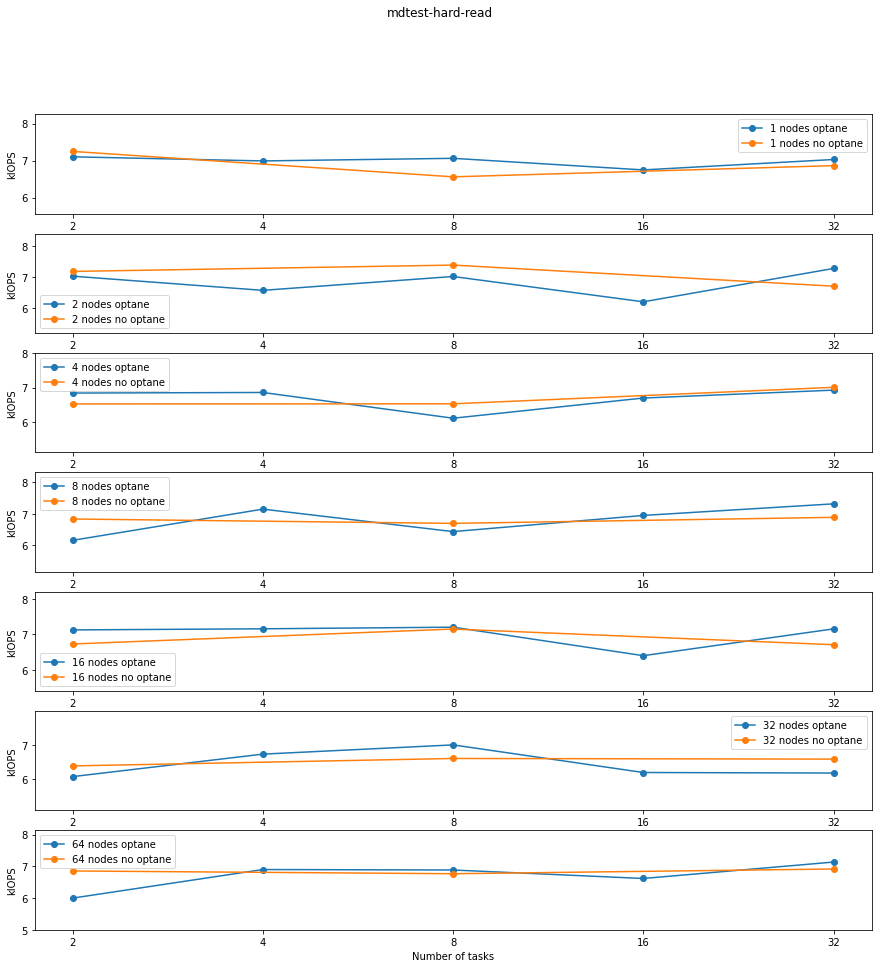

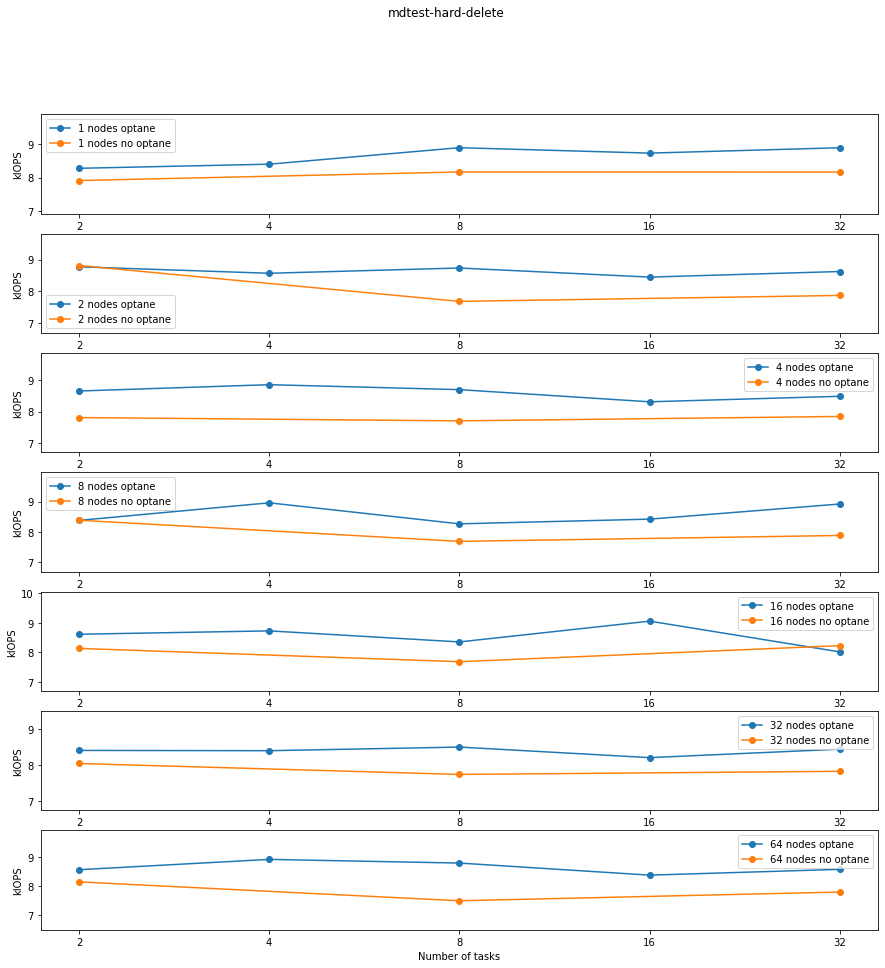

In [32]:
df = getDataset("/home/marco/Desktop/io500-optane") 
df1 = getDataset("/home/marco/Desktop/io500-no-optane")

index = 6
while index < len(df.columns):
    benchmarkGraphPlot(df, index, mainBenchmarkLabel="optane", compareToBenchmarkLabel="no optane", dfCompareTo=df1,benchmarkDataFrameIndexCompareTo= index)
    index += 3

   
    
